In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from optuna.integration import lightgbm as oplgb
import lightgbm as lgb
from sklearn.model_selection import train_test_split,KFold
from sklearn.metrics import mean_squared_error
from optuna.samplers import TPESampler
import japanize_matplotlib

In [1]:
#このセルを実行すると保存したモデルを初期化します
Data = pd.read_csv(r"Dataset.csv",index_col=0,encoding="cp932")

NameError: name 'pd' is not defined

In [3]:
models = {}

# 期間別時系列推移

In [4]:
# モード選択(Buy or Sell)
mode="Buy"
# 標準化
std_on=False

## データ前処理

- データはBuyとSell分析用に分けたあとそれぞれ上位1%を外れ値として除去
- 説明変数、被説明変数ともに標準化(平均：0，分散：1)
- 対象termを指定して期間を決定

In [5]:
if mode=="Buy":
    DataSetBuy = Data.drop(["ID", "ファンド名",\
                            "解約額", "解約額lag1", "販売手数料", "元本割れ頻度", "元本割れリスク", "シャープレシオ"],axis=1)
    DataSetBuy = DataSetBuy[DataSetBuy["設定額"]<DataSetBuy["設定額"].quantile(0.99)]
    
    #ここでtermを元データ(Data)から切り出しています
    # test_Data = DataSetBuy[DataSetBuy["月"].str.contains("2014")].drop(['月'],axis=1)
    DataSetBuy = DataSetBuy.loc[DataSetBuy[DataSetBuy["月"]=="2012/01"].index[0]\
                                :DataSetBuy[DataSetBuy["月"]=="2016/12"].index[-1]].drop(['月'],axis=1)
    
    #訓練データを説明変数データ(X_train)と目的変数データ(y_train)に分割
    X_train = DataSetBuy.drop('設定額', axis=1)
    Y_train = DataSetBuy['設定額']
    
#     X_test = test_Data.drop('設定額', axis=1)
#     Y_test = test_Data['設定額']
    
    if std_on:
        #標準化
        X_train = X_train.apply(lambda x: (x - x.mean()) / x.std())
        Y_train = (Y_train - Y_train.mean()) / Y_train.std()
#         X_test_scale = X_test.apply(lambda x: (x - x.mean()) / x.std())
#         y_test_scale = (Y_test - Y_test.mean()) / Y_test.std()

    
elif mode=="Sell":
    DataSetSell = Data.drop(["ID", "ファンド名",\
                             "設定額", "設定額lag1", "販売手数料", "元本割れ頻度", "元本割れリスク", "シャープレシオ"],axis=1)
    DataSetSell = DataSetSell[(DataSetSell["解約額"]<DataSetSell["解約額"].quantile(0.99))]
    
    #test_Data = DataSetSell[DataSetSell["月"].str.contains("2014")].drop(['月'],axis=1)
    DataSetSell = DataSetSell.loc[DataSetSell[DataSetSell["月"]=="2012/01"].index[0]\
                                  :DataSetSell[DataSetSell["月"]=="2016/12"].index[-1]].drop(['月'],axis=1)
    
    #訓練データを説明変数データ(X_train)と目的変数データ(y_train)に分割
    X_train = DataSetSell.drop('解約額', axis=1)
    Y_train = DataSetSell['解約額']
    
#     X_test = test_Data.drop('解約額', axis=1)
#     Y_test = test_Data['解約額']
    
    if std_on:
        # 標準化
        X_train = X_train.apply(lambda x: (x - x.mean()) / x.std())
        Y_train = (Y_train - Y_train.mean()) / Y_train.std()
#         X_test_scale = X_test.apply(lambda x: (x - x.mean()) / x.std())
#         Y_test_scale = (Y_test - Y_test.mean()) / Y_test.std()

else:
    print("Plese enter mode val 'Buy' or 'Sell'.")

## 学習（Optuna）

- 交差検証は10回行い、ハイパーパラメータを決定

In [6]:
# 訓練データ
lgb_train = lgb.Dataset(X_train, Y_train, free_raw_data = False)

kfold = KFold(n_splits=5,shuffle=True,random_state=0)

# 固定するパラメータ
params = {
    "boosting_type": "gbdt",
    'objective': 'regression',
    'metric': 'rmse',
    'random_state':0,
    "verbosity": -1
}

# Optunaでのパラメータ探索
tuner_cv = oplgb.LightGBMTunerCV(params, lgb_train, verbose_eval=-1,early_stopping_rounds=100,folds=kfold)

tuner_cv.run()

# 最適なパラメータの表示
best_params = tuner_cv.best_params
best_score = tuner_cv.best_score

test_size = 0.3  # 分割比率
x_train, x_test, y_train, y_test = train_test_split(X_train, Y_train, test_size=test_size, random_state=0)

lgb_train = lgb.Dataset(x_train, y_train, free_raw_data = False)
lgb_test = lgb.Dataset(x_test, y_test, reference=lgb_train)

# 最適化パラメータで学習器構成
model = lgb.train(best_params, lgb_train, valid_sets=[lgb_test],early_stopping_rounds=100,verbose_eval=-1)
models[mode] = model

[I 2021-10-29 17:23:45,471] A new study created in memory with name: no-name-8198d19f-c0d5-4d6d-8a59-4ca01e1322d3
feature_fraction, val_score: inf:   0%|          | 0/7 [00:00<?, ?it/s]/Users/chuudoutakuma/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:578: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/chuudoutakuma/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:621: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
feature_fraction, val_score: 0.028312:  14%|#4        | 1/7 [00:01<00:0

num_leaves, val_score: 0.028231:   5%|5         | 1/20 [00:04<01:28,  4.67s/it]/Users/chuudoutakuma/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:578: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/chuudoutakuma/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:621: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
num_leaves, val_score: 0.028231:  10%|#         | 2/20 [00:09<01:26,  4.80s/it]/Users/chuudoutakuma/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:578: UserWarning: 'e

/Users/chuudoutakuma/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:621: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
num_leaves, val_score: 0.028193:  45%|####5     | 9/20 [00:32<00:32,  2.97s/it]/Users/chuudoutakuma/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:578: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/chuudoutakuma/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:621: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of 

num_leaves, val_score: 0.028193:  80%|########  | 16/20 [00:57<00:10,  2.63s/it]/Users/chuudoutakuma/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:578: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/chuudoutakuma/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:621: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
num_leaves, val_score: 0.028193:  85%|########5 | 17/20 [01:01<00:09,  3.01s/it]/Users/chuudoutakuma/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:578: UserWarning: 

bagging, val_score: 0.028193:  40%|####      | 4/10 [00:06<00:10,  1.72s/it]/Users/chuudoutakuma/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:578: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/chuudoutakuma/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:621: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
bagging, val_score: 0.028193:  50%|#####     | 5/10 [00:08<00:08,  1.72s/it]/Users/chuudoutakuma/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:578: UserWarning: 'early_s

feature_fraction_stage2, val_score: 0.028193:  33%|###3      | 2/6 [00:03<00:06,  1.58s/it]/Users/chuudoutakuma/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:578: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/chuudoutakuma/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:621: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
feature_fraction_stage2, val_score: 0.028193:  50%|#####     | 3/6 [00:04<00:04,  1.51s/it]/Users/chuudoutakuma/anaconda3/lib/python3.7/site-packages/lightgbm/engine

regularization_factors, val_score: 0.028180:  15%|#5        | 3/20 [00:04<00:25,  1.48s/it]/Users/chuudoutakuma/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:578: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/chuudoutakuma/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:621: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
regularization_factors, val_score: 0.028180:  20%|##        | 4/20 [00:06<00:26,  1.67s/it]/Users/chuudoutakuma/anaconda3/lib/python3.7/site-packages/lightgbm/engine

regularization_factors, val_score: 0.028095:  55%|#####5    | 11/20 [00:18<00:14,  1.59s/it]/Users/chuudoutakuma/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:578: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/chuudoutakuma/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:621: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
regularization_factors, val_score: 0.028095:  60%|######    | 12/20 [00:19<00:12,  1.55s/it]/Users/chuudoutakuma/anaconda3/lib/python3.7/site-packages/lightgbm/engi

Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[96]	valid_0's rmse: 0.0295422



/Users/chuudoutakuma/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/chuudoutakuma/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:240: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


# 結果（Buy）

In [7]:
Buy_X = X_train
Buy_Y = Y_train
Buy_set = pd.concat([Buy_Y,Buy_X],axis=1,sort=False).reset_index(drop=True)
#Buy_set.to_csv()

In [8]:
#Buy all
best_params

{'boosting_type': 'gbdt',
 'objective': 'regression',
 'metric': 'rmse',
 'random_state': 0,
 'verbosity': -1,
 'feature_pre_filter': False,
 'lambda_l1': 0.13942041833829105,
 'lambda_l2': 0.007782466573165671,
 'num_leaves': 39,
 'feature_fraction': 0.52,
 'bagging_fraction': 1.0,
 'bagging_freq': 0,
 'min_child_samples': 20}

In [9]:
pred_list_Buy = []
y_true = np.array(Y_train)

Y_pred = model.predict(X_train)
nrmse_score = np.sqrt(mean_squared_error(y_true, Y_pred))
pred_list_Buy.append(nrmse_score)

Text(0, 0.5, 'pred')

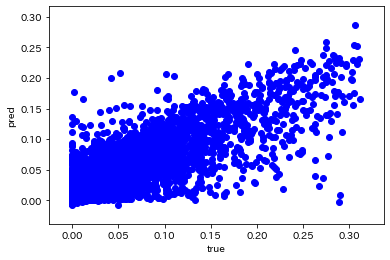

In [10]:
plt.scatter(Y_train, Y_pred,c='b')
plt.xlabel("true")
plt.ylabel("pred")
#plt.savefig()

# 結果（Sell）

In [7]:
Sell_X = X_train
Sell_Y = Y_train
Sell_set = pd.concat([Sell_Y,Sell_X],axis=1,sort=False).reset_index(drop=True)
#Sell_set.to_csv()

In [8]:
# Sell
best_params

{'boosting_type': 'gbdt',
 'objective': 'regression',
 'metric': 'rmse',
 'random_state': 0,
 'verbosity': -1,
 'feature_pre_filter': False,
 'lambda_l1': 1.8847466786271963e-05,
 'lambda_l2': 1.1787256281854725e-08,
 'num_leaves': 62,
 'feature_fraction': 0.6,
 'bagging_fraction': 1.0,
 'bagging_freq': 0,
 'min_child_samples': 20}

In [11]:
pred_list_Sell = []
y_true = np.array(Y_train)

Y_pred = model.predict(X_train)
nrmse_score = np.sqrt(mean_squared_error(y_true, Y_pred))
pred_list_Sell.append(nrmse_score)

Text(0, 0.5, 'pred')

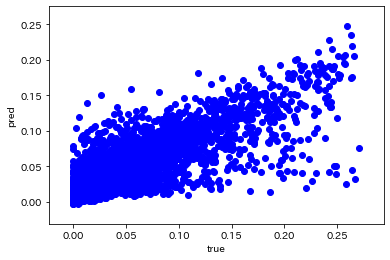

In [13]:
plt.scatter(Y_train, Y_pred,c='b');
plt.xlabel("true")
plt.ylabel("pred")
#plt.savefig()

# SHAPley(Buy)

In [11]:
import shap
shap.initjs()

In [12]:
# デフォルト設定
explainer = shap.TreeExplainer(model=models["Buy"])
exData = shap.sample(Buy_X,10000)
shap_v = explainer.shap_values(X=Buy_X)
Buy_shap_v = shap_v

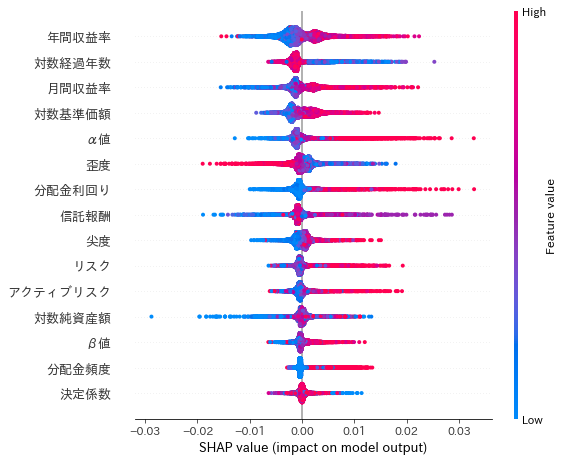

In [13]:
plt.figure(figsize=(15,15))
shap.summary_plot(shap_values=Buy_shap_v[:,1:],\
                  features=Buy_X.iloc[:,1:],feature_names=Buy_X.columns[1:],\
                  show=False,max_display=20)
#plt.savefig(PATH, dpi=200, bbox_inches="tight", pad_inches=0.1)

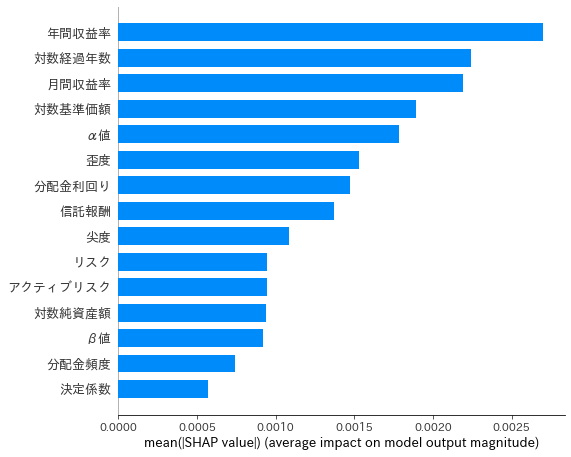

In [14]:
plt.figure(figsize=(15,15))
shap.summary_plot(shap_values=Buy_shap_v[:,1:],\
                  features=Buy_X.iloc[:,1:],feature_names=Buy_X.columns[1:],\
                  show=False,plot_type="bar",max_display=20)
# plt.savefig(PATH, dpi=200, bbox_inches="tight", pad_inches=0.1)

In [15]:
# SHAP相関図の表示＆保存
def shap_plot(shap_v, X, mode, col_name, save):
    plt.figure(figsize=(15,15))
    shap.dependence_plot(ind=col_name, shap_values=shap_v,features=X,show=False,interaction_index=None)
    if save:
        plt.savefig(r"..\..\Fig\{}_{}.svg".format(mode,col_name)\
                    , dpi=200, bbox_inches="tight", pad_inches=0.1)

<Figure size 1080x1080 with 0 Axes>

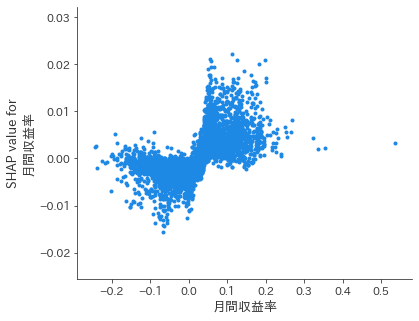

In [16]:
shap_plot(Buy_shap_v, Buy_X, 'Buy', '月間収益率', False)# 基準価額の値は対数変換されています

<Figure size 1080x1080 with 0 Axes>

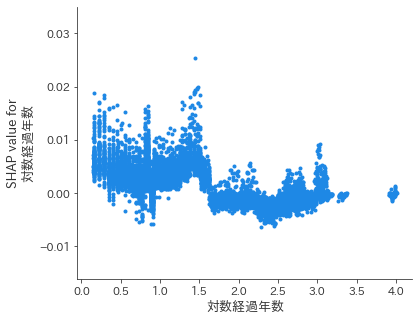

In [17]:
shap_plot(Buy_shap_v, Buy_X, 'Buy', '対数経過年数', False)

<Figure size 1080x1080 with 0 Axes>

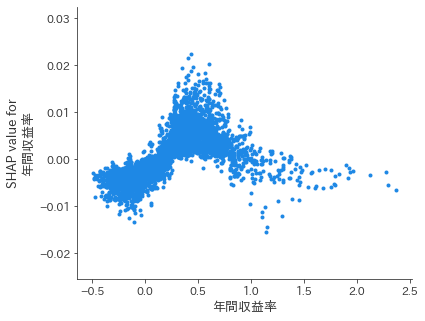

In [18]:
shap_plot(Buy_shap_v, Buy_X, 'Buy', '年間収益率', False)

<Figure size 1080x1080 with 0 Axes>

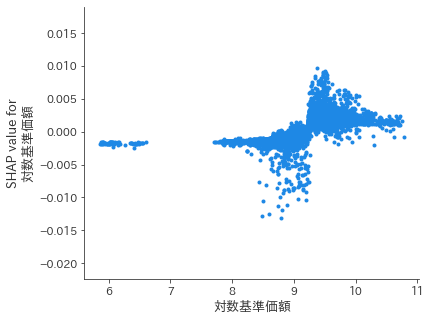

In [21]:
shap_plot(Buy_shap_v, Buy_X, 'Buy', '対数基準価額', False)

<Figure size 1080x1080 with 0 Axes>

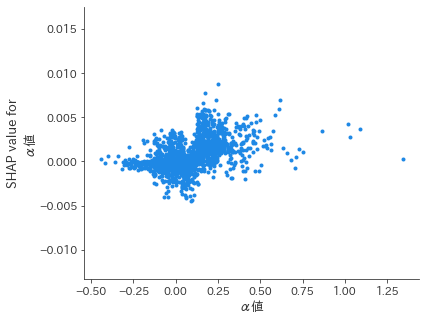

In [22]:
shap_plot(Buy_shap_v, Buy_X, 'Buy', 'α値', False)

<Figure size 1080x1080 with 0 Axes>

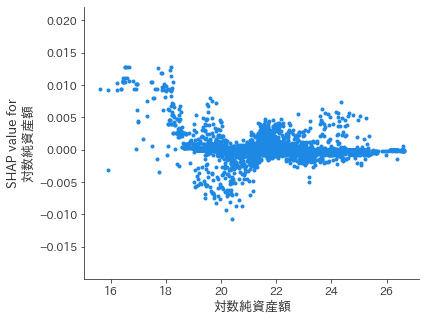

In [23]:
shap_plot(Buy_shap_v, Buy_X, 'Buy', '対数純資産額', False)

<Figure size 1080x1080 with 0 Axes>

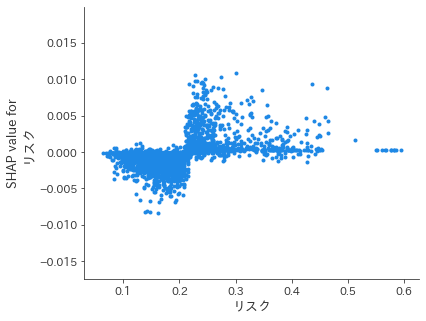

In [24]:
shap_plot(Buy_shap_v, Buy_X, 'Buy', 'リスク',False)

<Figure size 1080x1080 with 0 Axes>

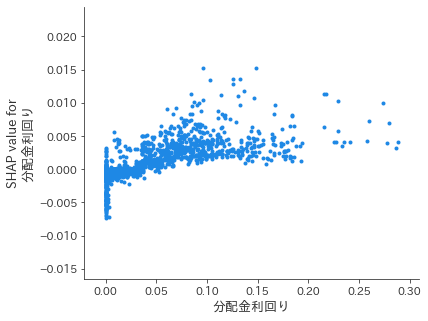

In [25]:
shap_plot(Buy_shap_v, Buy_X, 'Buy', '分配金利回り', False)

In [19]:
DF_Buy_shap = pd.DataFrame(Buy_shap_v,columns=Buy_X.columns[:])
DF_Buy_shap.to_csv("Buy_sv_term3.csv")

DF_Buy = pd.DataFrame(Buy_X,columns=Buy_X.columns[:])
DF_Buy.to_csv("Buy_term3.csv")

DF_Buy_shap

,設定額lag1,対数純資産額,対数基準価額,月間収益率,年間収益率,リスク,歪度,尖度,分配金利回り,対数経過年数,α値,β値,決定係数,アクティブリスク,信託報酬,分配金頻度
0,-0.012842,0.000111,-0.001833,-0.001165,-0.002263,-0.000650,0.001565,-0.000568,-0.000613,-0.001252,0.000696,0.000437,0.000110,-0.000397,-0.000571,-0.000446
1,-0.007664,0.000294,-0.003198,-0.001714,-0.003681,-0.000714,0.001540,0.001116,-0.000396,0.006927,-0.000533,0.000084,0.000129,-0.001808,-0.001336,-0.000365
2,-0.010764,0.000010,-0.002133,-0.001408,-0.002124,-0.000347,0.000951,0.000613,-0.000564,-0.000896,-0.000823,-0.000207,0.000113,-0.000499,-0.000867,-0.000503
3,-0.010461,-0.000103,-0.001912,-0.001255,-0.002624,-0.000222,0.000430,0.001231,-0.000928,-0.000697,-0.001533,-0.000410,0.000059,-0.000199,0.000268,-0.000286
4,0.007295,0.000973,-0.001429,-0.001336,-0.002963,-0.000187,-0.000130,0.001195,-0.001477,0.006453,-0.000177,-0.000265,-0.001357,0.006860,-0.000312,-0.000228
5,-0.012711,0.000203,-0.001944,-0.001232,-0.002206,-0.000477,0.001556,0.000748,-0.000678,-0.001201,-0.000901,0.000106,0.000268,-0.000566,-0.000949,-0.000622
6,-0.012197,0.000260,-0.001427,-0.001171,-0.001928,-0.000618,0.001683,0.001101,-0.000724,-0.001243,-0.000960,0.000043,-0.000254,-0.000630,-0.000983,-0.000478
7,-0.012943,-0.000373,-0.001762,-0.000722,-0.001819,-0.000412,-0.000442,0.000748,-0.000542,-0.000988,-0.000643,-0.000421,0.000119,-0.000370,0.000116,-0.000372
8,-0.013911,0.000508,-0.002075,-0.000950,-0.001363,-0.000824,-0.000184,0.000548,-0.000560,-0.001491,-0.000594,-0.000876,-0.000463,0.000148,-0.000758,-0.000321
9,-0.010610,-0.000411,-0.002004,-0.000980,-0.003285,0.000589,0.001062,0.001672,-0.001620,0.005404,0.000330,-0.002075,-0.000927,-0.000635,-0.000690,-0.002445


#  

## 特定ファンド

In [20]:
target_data_term3 = pd.read_csv(r"/Users/chuudoutakuma/投信資金フロー/中道/for_nakamichi/プログラム/allterm/target_data_term3.csv",index_col=0)

In [21]:
target_Buy_X = target_data_term3.drop(["ID", "ファンド名","設定額","月",\
                            "解約額", "解約額lag1", "販売手数料", "元本割れ頻度", "元本割れリスク", "シャープレシオ"],axis=1)
target_Buy_Y = target_data_term3['設定額']
target_Buy_set = pd.concat([target_Buy_Y,target_Buy_X],axis=1,sort=False).reset_index(drop=True)

In [22]:
explainer = shap.TreeExplainer(model=models["Buy"])
exData = shap.sample(target_Buy_X,10000)
shap_v = explainer.shap_values(X=target_Buy_X)
Buy_shap_v = shap_v

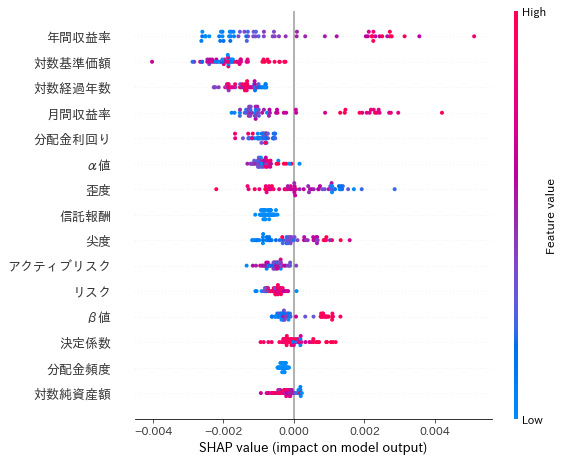

In [23]:
plt.figure(figsize=(15,15))
shap.summary_plot(shap_values=Buy_shap_v[:,1:],\
                  features=target_Buy_X.iloc[:,1:],feature_names=target_Buy_X.columns[1:],\
                  show=False,max_display=20)
#plt.savefig(PATH, dpi=200, bbox_inches="tight", pad_inches=0.1)

In [24]:
DF_target_Buy_shap = pd.DataFrame(Buy_shap_v,columns=target_Buy_X.columns[:])
DF_target_Buy_shap.to_csv("target_Buy_sv_term3.csv")

DF_target_Buy = pd.DataFrame(target_Buy_X,columns=target_Buy_X.columns[:])
DF_target_Buy.to_csv("target_Buy_term3.csv")

DF_target_Buy_shap

,設定額lag1,対数純資産額,対数基準価額,月間収益率,年間収益率,リスク,歪度,尖度,分配金利回り,対数経過年数,α値,β値,決定係数,アクティブリスク,信託報酬,分配金頻度
0,-0.011947,-0.000267,-0.001775,-0.001285,-0.002518,-0.000534,0.001085,0.000865,-0.001170,-0.000803,-0.001173,-0.000113,-0.000009,-0.000530,-0.000704,-0.000467
1,-0.012657,-0.000289,-0.001734,-0.000507,-0.002600,-0.000460,0.001059,0.000910,-0.001299,-0.000811,-0.001128,-0.000361,-0.000026,-0.000509,-0.000699,-0.000436
2,-0.013777,-0.000260,-0.002606,0.001862,-0.001822,-0.000167,-0.000580,0.001326,-0.001668,-0.000857,-0.001020,-0.000098,0.000111,-0.000354,-0.000843,-0.000290
3,-0.012795,-0.000283,-0.002031,0.000063,-0.002000,-0.000283,0.000277,0.001080,-0.001672,-0.000797,-0.001029,0.000058,0.000327,-0.000734,-0.000829,-0.000388
4,-0.012132,-0.000107,-0.001775,-0.001109,-0.002028,-0.000396,-0.000092,0.000920,-0.000968,-0.000961,-0.000997,-0.000319,0.000192,-0.000532,-0.000710,-0.000330
5,-0.012182,-0.000064,-0.001750,-0.001085,-0.001840,-0.000401,0.000012,0.000632,-0.000853,-0.000928,-0.000994,-0.000219,-0.000023,-0.000403,-0.000856,-0.000361
6,-0.014418,-0.000207,-0.001857,0.002064,-0.002508,-0.000528,0.000688,0.000016,-0.000894,-0.000906,-0.000968,-0.000424,-0.000003,-0.000334,-0.000580,-0.000196
7,-0.012136,-0.000063,-0.001859,-0.000996,-0.001791,-0.000499,0.000035,-0.000019,-0.000781,-0.000846,-0.000927,-0.000191,0.000210,-0.000575,-0.000937,-0.000311
8,-0.012365,-0.000009,-0.001878,-0.001187,-0.001807,-0.000478,0.000056,0.000625,-0.000821,-0.000783,-0.000844,-0.000429,-0.000177,-0.000465,-0.000557,-0.000296
9,-0.013010,-0.000075,-0.002144,-0.000709,-0.001309,-0.000506,0.000738,0.000556,-0.000867,-0.000807,-0.000781,-0.000484,-0.000215,-0.000475,-0.000609,-0.000269


# SHAPley(Sell)

In [15]:
import shap
#plt.rcParams['font.family'] = "Yu Gothic"
shap.initjs()

In [18]:
# デフォルト設定
explainer = shap.TreeExplainer(model=models["Sell"])
exData = shap.sample(Sell_X,10000)
shap_v = explainer.shap_values(X=Sell_X)
Sell_shap_v = shap_v

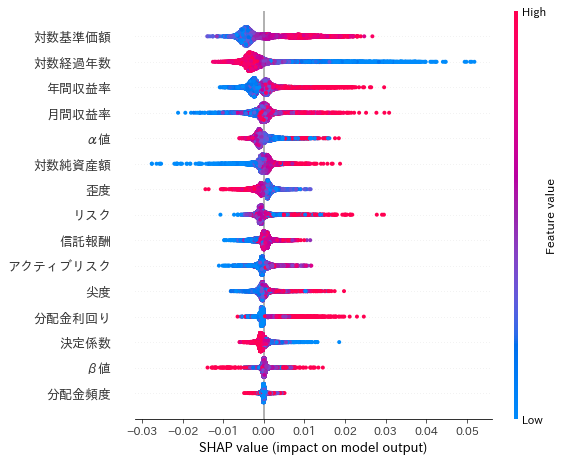

In [21]:
plt.figure(figsize=(15,15))
shap.summary_plot(shap_values=Sell_shap_v[:,1:],\
                  features=Sell_X.iloc[:,1:],feature_names=Sell_X.columns[1:],\
                  show=False,max_display=20)
#plt.savefig(PATH, dpi=200, bbox_inches="tight", pad_inches=0.1)

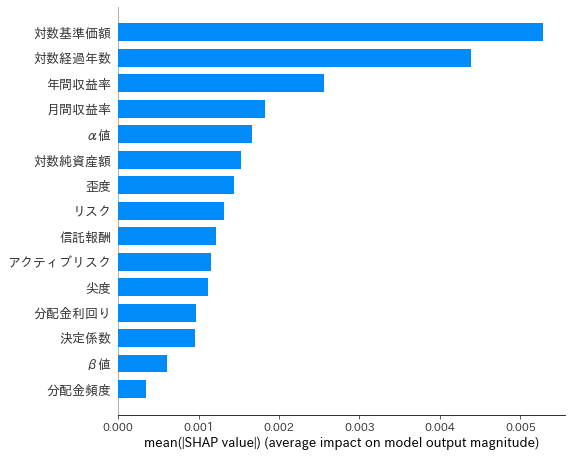

In [23]:
plt.figure(figsize=(15,15))
shap.summary_plot(shap_values=Sell_shap_v[:,1:],\
                  features=Sell_X.iloc[:,1:],feature_names=Sell_X.columns[1:],\
                  show=False,max_display=20,plot_type="bar")
#plt.savefig(PATH, dpi=200, bbox_inches="tight", pad_inches=0.1)

In [29]:
def shap_plot(shap_v, X, mode, col_name, save):
    plt.figure(figsize=(15,15))
    shap.dependence_plot(ind=col_name, shap_values=shap_v,features=X,show=False,interaction_index=None)
    if save:
        plt.savefig(r"..\..\Fig\{}_{}.svg".format(mode,col_name)\
                    , dpi=200, bbox_inches="tight", pad_inches=0.1)

<Figure size 1080x1080 with 0 Axes>

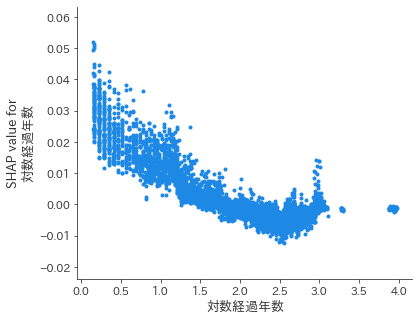

In [30]:
shap_plot(Sell_shap_v, Sell_X, 'Sell', '対数経過年数', False)

<Figure size 1080x1080 with 0 Axes>

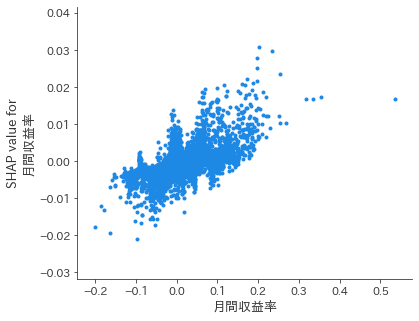

In [31]:
shap_plot(Sell_shap_v, Sell_X, 'Sell', '月間収益率', False)

<Figure size 1080x1080 with 0 Axes>

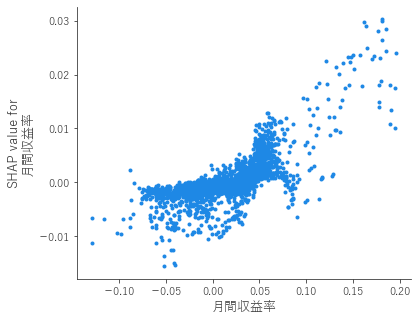

In [22]:
shap_plot(Sell_shap_v, X_test, 'Sell', '月間収益率', False)

<Figure size 1080x1080 with 0 Axes>

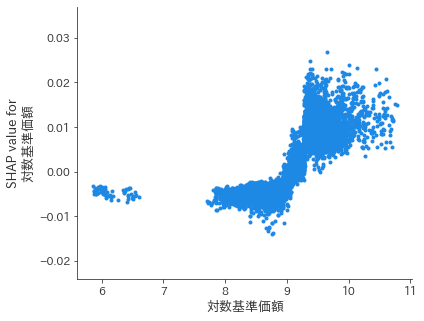

In [32]:
shap_plot(Sell_shap_v,Sell_X, 'Sell', '対数基準価額', False)

<Figure size 1080x1080 with 0 Axes>

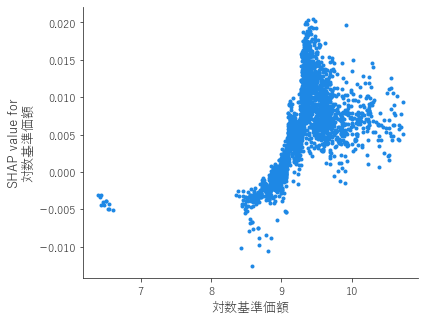

In [23]:
shap_plot(Sell_shap_v, X_test, 'Sell', '対数基準価額', False)

<Figure size 1080x1080 with 0 Axes>

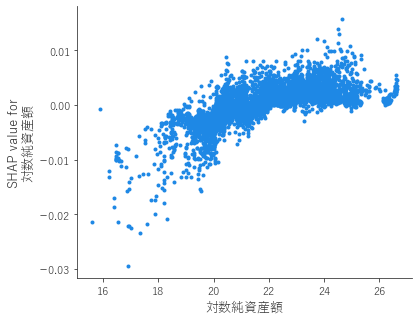

In [50]:
shap_plot(Sell_shap_v, Sell_X, 'Sell', '対数純資産額', True)

<Figure size 1080x1080 with 0 Axes>

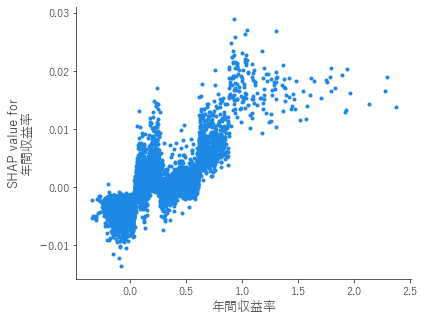

In [47]:
shap_plot(Sell_shap_v, Sell_X, 'Sell', '年間収益率', True)

<Figure size 1080x1080 with 0 Axes>

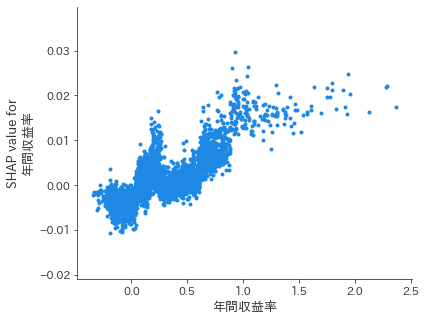

In [34]:
shap_plot(Sell_shap_v, Sell_X, 'Sell', '年間収益率', True)

<Figure size 1080x1080 with 0 Axes>

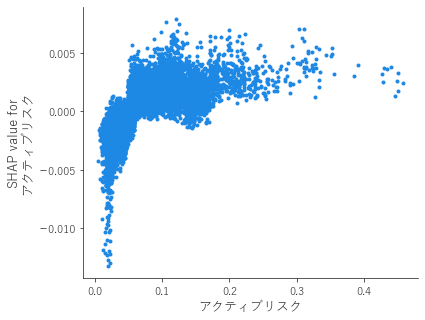

In [64]:
shap_plot(Sell_shap_v, Sell_X, 'Sell', 'アクティブリスク', True)

<Figure size 1080x1080 with 0 Axes>

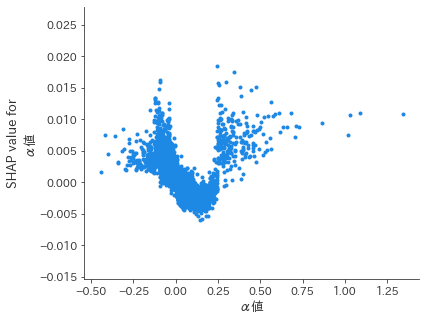

In [33]:
shap_plot(Sell_shap_v, Sell_X, 'Sell', 'α値', True)

<Figure size 1080x1080 with 0 Axes>

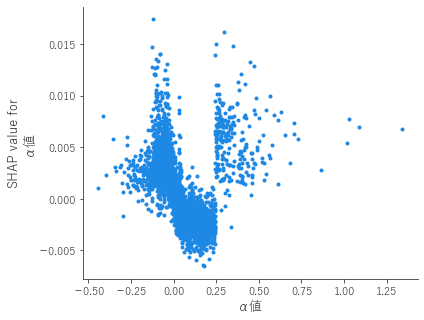

In [48]:
shap_plot(Sell_shap_v, Sell_X, 'Sell', 'α値', True)

<Figure size 1080x1080 with 0 Axes>

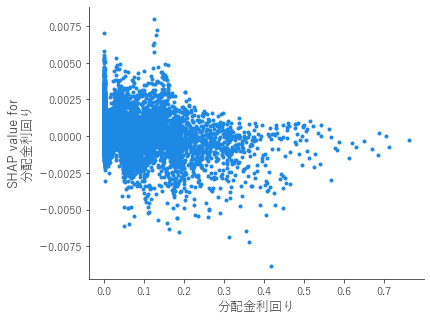

In [72]:
shap_plot(Sell_shap_v, Sell_X, 'Sell', '分配金利回り', False)

In [49]:
DF_Sell_shap = pd.DataFrame(Sell_shap_v,columns=Sell_X.columns[:])
DF_Sell_shap.to_csv()
DF_Sell_shap

,解約額lag1,対数純資産額,対数基準価額,月間収益率,年間収益率,リスク,歪度,尖度,分配金利回り,対数経過年数,α値,β値,決定係数,アクティブリスク,信託報酬,分配金頻度
0,0.019862,-0.000201,-0.005300,0.002988,0.001431,-0.000462,-0.002683,-0.004216,-0.000591,-0.005013,-0.002524,0.000580,-0.000274,0.001818,0.002326,0.000230
1,0.022761,0.002025,-0.005464,-0.001104,0.000008,0.000147,0.000283,0.005095,-0.000676,0.014170,-0.000733,-0.000300,-0.000792,-0.000671,0.003361,0.000321
2,-0.005590,0.000781,-0.005542,-0.000166,0.000688,-0.000386,-0.000521,0.001728,-0.000501,-0.004101,-0.001097,0.000029,-0.000076,0.000204,0.000351,0.000155
3,-0.004679,-0.000085,-0.005819,-0.000309,0.000979,-0.000585,0.001262,-0.001125,-0.000398,-0.003099,-0.001718,0.000023,0.000393,0.001060,-0.000859,0.000430
4,-0.003119,0.002625,-0.004487,-0.000096,0.001360,-0.000722,-0.000177,-0.001432,-0.000406,-0.001344,-0.000871,0.000254,-0.000495,-0.001249,0.000404,-0.000116
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11400,0.020089,-0.000062,0.007273,0.002546,-0.004850,-0.001187,-0.001986,0.001336,-0.000159,-0.002462,0.002286,-0.001279,0.003151,-0.001548,-0.002860,-0.000228
11401,0.020520,0.000427,-0.006735,-0.001256,0.001205,-0.002090,-0.001415,0.005641,0.000047,-0.002750,0.001160,0.000853,0.005721,0.000720,0.000958,-0.000018
11402,0.044422,0.006032,0.022504,0.003597,0.007003,0.008174,0.005411,0.005479,0.001060,0.004584,0.012105,0.005634,0.011959,0.009664,0.003488,-0.000132
11403,0.035301,0.005905,0.016795,0.004753,-0.000307,-0.002053,0.000631,0.001531,0.000806,0.003226,0.006854,0.000907,-0.001123,-0.010146,0.000665,0.000505
